In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt

In [4]:
allGenres = pd.read_csv('data.csv')
#df_ylabels = allGenres['label']

In [5]:
allGenres.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [6]:
allGenres['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [7]:
allGenres.isna().sum()

filename              0
tempo                 0
beats                 0
chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
label                 0
dtype: int64

In [8]:
columns_to_drop = ['label','filename']

def prepare_dataset(df, columns_to_drop, test_size):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train[['label']].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test[['label']] 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [9]:
X_train, y_train, X_test, y_test = prepare_dataset(allGenres, columns_to_drop, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 28) (700, 1)
(300, 28) (300, 1)


# Deep learning with neural network - Tensorflow

In [10]:
def getModel(neurone_size,first_layer_activation, second_layer_activation, add_dropout):
    # Inputs -> Dense -> Dropout -> Dense (Output)
    model = keras.Sequential()
    model.add(layers.Dense(neurone_size, activation=first_layer_activation, input_dim=X_train.shape[1]))
    # Parameterized Dropout if required
    if(add_dropout):
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(allGenres['label'].nunique(), activation=second_layer_activation))
    return model

def getOptimizer():
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam()
    return optimizer

In [11]:
loss = "sparse_categorical_crossentropy"
#loss = tf.keras.losses.CategoricalCrossentropy()
metrics=['accuracy']
optimizer = getOptimizer()

# Model with 16 neurons WITH dropout layer
model_with_16_dropout = getModel(16,"relu", "softmax", add_dropout=True)
model_with_16_dropout.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Model with 16 neurons WITHOUT dropout layer
model_with_16_no_dropout = getModel(16,"relu", "softmax", add_dropout=False)
model_with_16_no_dropout.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Model with 32 neurons WITH dropout layer
model_with_32_dropout = getModel(32,"relu", "softmax", add_dropout=True)
model_with_32_dropout.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Model with 32 neurons WITHOUT dropout layer
model_with_32_no_dropout = getModel(32,"relu", "softmax", add_dropout=False)
model_with_32_no_dropout.compile(loss=loss, optimizer=optimizer, metrics=metrics)


In [12]:
#!pip install pydot==1.2.3
#!pip install pydotplus
#!pip install graphviz

In [13]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 50
verbose = 1
batch_size = 4

# Fit both models
print("-----------------------MODEL 16 NEURONS WITH DROPOUT LAYER------------------------------")
history_model_with_16_dropout = model_with_16_dropout.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)
print("-----------------------MODEL 16 NEURONS WITHOUT DROPOUT LAYER------------------------------")
history_model_with_16_no_dropout = model_with_16_no_dropout.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)
print("-----------------------MODEL 32 NEURONS WITH DROPOUT LAYER------------------------------")
history_model_with_32_dropout =model_with_32_dropout.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)
print("-----------------------MODEL 32 NEURONS WITHOUT DROPOUT LAYER------------------------------")
history_model_with_32_no_dropout =model_with_32_no_dropout.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)

-----------------------MODEL 16 NEURONS WITH DROPOUT LAYER------------------------------
Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 2.5575 - accuracy: 0.1457 - val_loss: 2.1370 - val_accuracy: 0.2467
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 2.1099 - accuracy: 0.2171 - val_loss: 1.8717 - val_accuracy: 0.3500
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 1.9160 - accuracy: 0.3157 - val_loss: 1.7319 - val_accuracy: 0.3700
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 1.8096 - accuracy: 0.3600 - val_loss: 1.6423 - val_accuracy: 0.4167
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 1.7038 - accuracy: 0.3886 - val_loss: 1.5696 - val_accuracy: 0.4333
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 1.6589 - accuracy: 0.4000 - val_loss: 1.5162 - val_accuracy: 0.4400
Epoch 7/50
175/175 [==============================] - 0s 1m

175/175 [==============================] - 0s 2ms/step - loss: 1.1252 - accuracy: 0.6086 - val_loss: 1.2143 - val_accuracy: 0.5900
Epoch 8/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0934 - accuracy: 0.6100 - val_loss: 1.2049 - val_accuracy: 0.5967
Epoch 9/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0623 - accuracy: 0.6186 - val_loss: 1.1944 - val_accuracy: 0.6133
Epoch 10/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0392 - accuracy: 0.6429 - val_loss: 1.1775 - val_accuracy: 0.5967
Epoch 11/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0172 - accuracy: 0.6543 - val_loss: 1.1651 - val_accuracy: 0.5867
Epoch 12/50
175/175 [==============================] - 0s 2ms/step - loss: 0.9956 - accuracy: 0.6586 - val_loss: 1.1577 - val_accuracy: 0.5967
Epoch 13/50
175/175 [==============================] - 0s 1ms/step - loss: 0.9783 - accuracy: 0.6700 - val_loss: 1.1557 - val_accuracy: 0.6000
Epoch 14/50
1

Epoch 14/50
175/175 [==============================] - 0s 1ms/step - loss: 1.0403 - accuracy: 0.6343 - val_loss: 1.1383 - val_accuracy: 0.6167
Epoch 15/50
175/175 [==============================] - 0s 1ms/step - loss: 1.0059 - accuracy: 0.6357 - val_loss: 1.1264 - val_accuracy: 0.6267
Epoch 16/50
175/175 [==============================] - 0s 1ms/step - loss: 1.0661 - accuracy: 0.6029 - val_loss: 1.1248 - val_accuracy: 0.6433
Epoch 17/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0486 - accuracy: 0.6014 - val_loss: 1.1194 - val_accuracy: 0.6400
Epoch 18/50
175/175 [==============================] - 0s 2ms/step - loss: 1.0405 - accuracy: 0.6200 - val_loss: 1.1183 - val_accuracy: 0.6300
Epoch 19/50
175/175 [==============================] - 0s 3ms/step - loss: 1.0089 - accuracy: 0.6386 - val_loss: 1.1204 - val_accuracy: 0.6300
Epoch 20/50
175/175 [==============================] - 0s 2ms/step - loss: 0.9708 - accuracy: 0.6557 - val_loss: 1.1161 - val_accuracy: 0.6333

Epoch 21/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6151 - accuracy: 0.8071 - val_loss: 1.1644 - val_accuracy: 0.6533
Epoch 22/50
175/175 [==============================] - 0s 1ms/step - loss: 0.6076 - accuracy: 0.8086 - val_loss: 1.1544 - val_accuracy: 0.6433
Epoch 23/50
175/175 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.8143 - val_loss: 1.1467 - val_accuracy: 0.6333
Epoch 24/50
175/175 [==============================] - 0s 3ms/step - loss: 0.5805 - accuracy: 0.8200 - val_loss: 1.1574 - val_accuracy: 0.6333
Epoch 25/50
175/175 [==============================] - 0s 3ms/step - loss: 0.5687 - accuracy: 0.8200 - val_loss: 1.1723 - val_accuracy: 0.6400
Epoch 26/50
175/175 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.8157 - val_loss: 1.1621 - val_accuracy: 0.6367
Epoch 27/50
175/175 [==============================] - 0s 2ms/step - loss: 0.5483 - accuracy: 0.8386 - val_loss: 1.1860 - val_accuracy: 0.6467

In [15]:
print("-----------------------MODEL 16 NEURONS WITH DROPOUT LAYER------------------------------")
model_with_16_dropout.summary()
print("-----------------------MODEL 16 NEURONS WITHOUT DROPOUT LAYER------------------------------")
model_with_16_no_dropout.summary()

-----------------------MODEL 16 NEURONS WITH DROPOUT LAYER------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________
-----------------------MODEL 16 NEURONS WITHOUT DROPOUT LAYER------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape            

In [16]:
print("-----------------------MODEL 32 NEURONS WITH DROPOUT LAYER------------------------------")
model_with_32_dropout.summary()
print("-----------------------MODEL 32 NEURONS WITHOUT DROPOUT LAYER------------------------------")
model_with_32_no_dropout.summary()

-----------------------MODEL 32 NEURONS WITH DROPOUT LAYER------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                928       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 1,258
Trainable params: 1,258
Non-trainable params: 0
_________________________________________________________________
-----------------------MODEL 32 NEURONS WITHOUT DROPOUT LAYER------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape      

# Plotting Accuracy against Training Epochs

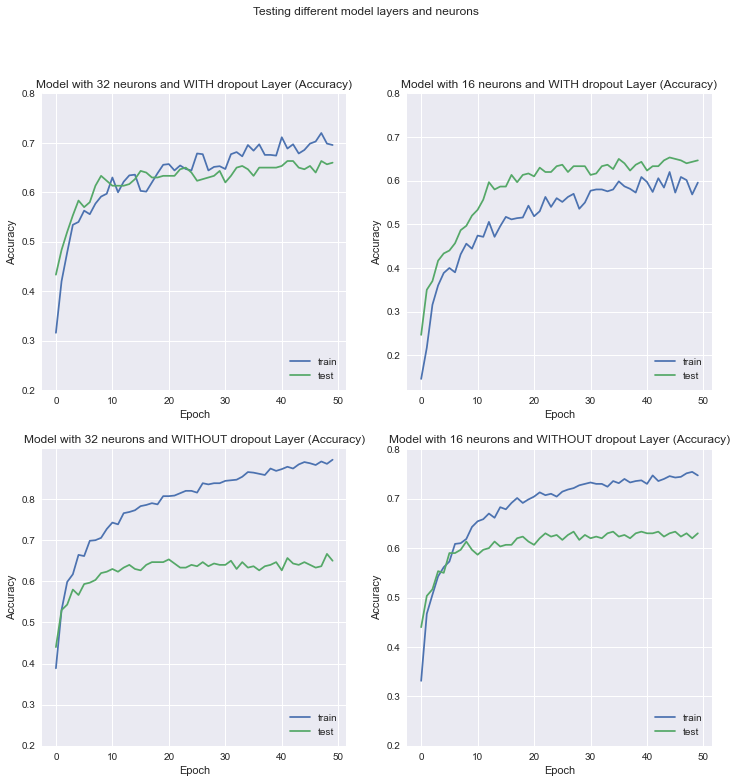

In [17]:
plt.style.use("seaborn")

# Plot Configuration
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Testing different model layers and neurons')

# Plot for model with 32 neurons with dropout
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history_model_with_32_dropout.history['accuracy']
val_accuracy = history_model_with_32_dropout.history['val_accuracy']

# Plotting
ax1.plot(accuracy)
ax1.plot(val_accuracy)

# Labelling
ax1.set_title('Model with 32 neurons and WITH dropout Layer (Accuracy)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'test'], loc='lower right')
ax1.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

# Plot for model with 16 neurons and WITH dropout Layer
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history_model_with_16_dropout.history['accuracy']
val_accuracy = history_model_with_16_dropout.history['val_accuracy']

# Plotting
ax2.plot(accuracy)
ax2.plot(val_accuracy)

# Labelling
ax2.set_title('Model with 16 neurons and WITH dropout Layer (Accuracy)')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'test'], loc='lower right')
ax2.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

# Plot for model with 32 neurons WITHOUT dropout
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history_model_with_32_no_dropout.history['accuracy']
val_accuracy = history_model_with_32_no_dropout.history['val_accuracy']

# Plotting
ax3.plot(accuracy)
ax3.plot(val_accuracy)

# Labelling
ax3.set_title('Model with 32 neurons and WITHOUT dropout Layer (Accuracy)')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epoch')
ax3.legend(['train', 'test'], loc='lower right')
ax3.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

# Plot for model with 16 neurons and WITHOUT dropout Layer
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history_model_with_16_no_dropout.history['accuracy']
val_accuracy = history_model_with_16_no_dropout.history['val_accuracy']

# Plotting
ax4.plot(accuracy)
ax4.plot(val_accuracy)

# Labelling
ax4.set_title('Model with 16 neurons and WITHOUT dropout Layer (Accuracy)')
ax4.set_ylabel('Accuracy')
ax4.set_xlabel('Epoch')
ax4.legend(['train', 'test'], loc='lower right')
ax4.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

plt.show()

# Plotting Loss against Training Epochs

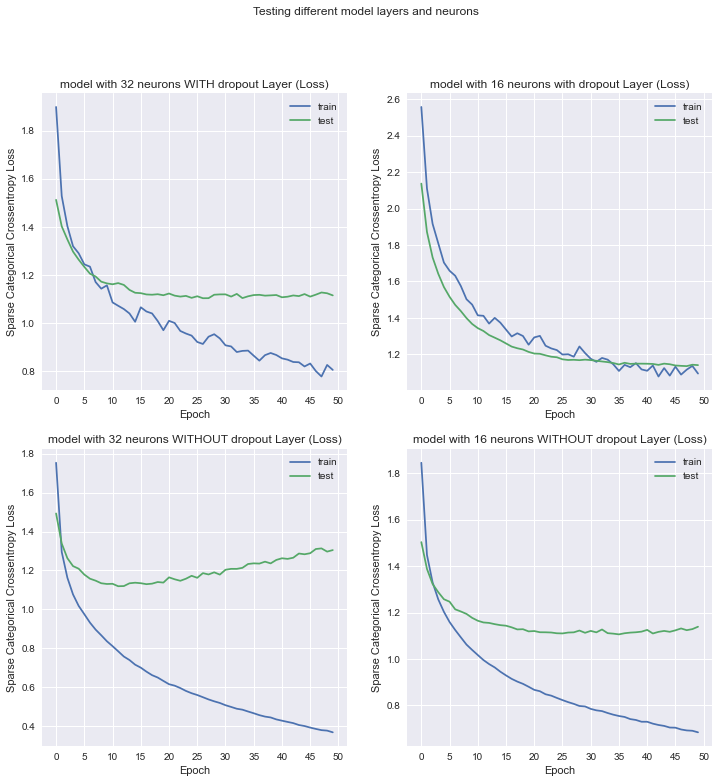

In [18]:
plt.style.use("seaborn")

# Plot Configuration
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle('Testing different model layers and neurons')

# Plot for model with 32 neurons WITH dropout
# ------
# Extracting Train & Test Loss from model history
loss = history_model_with_32_dropout.history['loss']
val_loss = history_model_with_32_dropout.history['val_loss']

# Plotting
ax1.plot(loss)
ax1.plot(val_loss)

# Labelling
ax1.set_title('model with 32 neurons WITH dropout Layer (Loss)')
ax1.set_ylabel('Sparse Categorical Crossentropy Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'test'], loc='upper right')
ax1.set_xticks(np.arange(0, 50+1, 5.0))
# ------

# Plot for model with 16 neurons WITH dropout
# ------
# Extracting Train & Test Loss from model history
loss = history_model_with_16_dropout.history['loss']
val_loss = history_model_with_16_dropout.history['val_loss']

# Plotting
ax2.plot(loss)
ax2.plot(val_loss)

# Labelling
ax2.set_title('model with 16 neurons with dropout Layer (Loss)')
ax2.set_ylabel('Sparse Categorical Crossentropy Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'test'], loc='upper right')
ax2.set_xticks(np.arange(0, 50+1, 5.0))
# ------


# Plot for model with 32 neurons WITHOUT dropout
# ------
# Extracting Train & Test Loss from model history
loss = history_model_with_32_no_dropout.history['loss']
val_loss = history_model_with_32_no_dropout.history['val_loss']

# Plotting
ax3.plot(loss)
ax3.plot(val_loss)

# Labelling
ax3.set_title('model with 32 neurons WITHOUT dropout Layer (Loss)')
ax3.set_ylabel('Sparse Categorical Crossentropy Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['train', 'test'], loc='upper right')
ax3.set_xticks(np.arange(0, 50+1, 5.0))
# ------

# Plot for model with 16 neurons WITHOUT dropout
# ------
# Extracting Train & Test Loss from model history
loss = history_model_with_16_no_dropout.history['loss']
val_loss = history_model_with_16_no_dropout.history['val_loss']

# Plotting
ax4.plot(loss)
ax4.plot(val_loss)

# Labelling
ax4.set_title('model with 16 neurons WITHOUT dropout Layer (Loss)')
ax4.set_ylabel('Sparse Categorical Crossentropy Loss')
ax4.set_xlabel('Epoch')
ax4.legend(['train', 'test'], loc='upper right')
ax4.set_xticks(np.arange(0, 50+1, 5.0))
# ------

plt.show()

# Model Evaluation with 32 neurons 

In [19]:

#score with 32 neurons and WITH dropout Layer
score = model_with_32_dropout.evaluate(X_test, y_test)

score_df = pd.Series(score, index = model_with_32_dropout.metrics_names)

score_df

10/10 [==============================] - 0s 2ms/step - loss: 1.1155 - accuracy: 0.6600


loss        1.115493
accuracy    0.660000
dtype: float64

# Preditcting the model

In [20]:
y_pred = model_with_32_dropout.predict(X_test,verbose=1)

y_pred[:10]

10/10 [==============================] - 0s 887us/step


array([[1.4311949e-09, 1.8117181e-08, 1.1974270e-02, 1.1152726e-01,
        2.1248953e-01, 1.0669315e-02, 2.0961485e-05, 3.4535730e-01,
        2.7137604e-01, 3.6585350e-02],
       [2.0203291e-01, 5.0288357e-04, 4.6737519e-01, 1.5131836e-02,
        4.7753577e-04, 1.5886034e-01, 4.3277811e-05, 6.1416058e-06,
        2.4641098e-03, 1.5310571e-01],
       [1.9963227e-02, 2.4635162e-02, 1.9238990e-02, 5.2067656e-03,
        2.2708925e-06, 9.2134583e-01, 1.6435010e-08, 7.3629076e-04,
        9.2039956e-04, 7.9509541e-03],
       [4.8696544e-05, 5.6708313e-04, 1.8034372e-04, 4.2477304e-01,
        4.5203599e-01, 9.3821390e-03, 7.1426950e-02, 9.0284325e-04,
        7.6647978e-03, 3.3018235e-02],
       [2.0078752e-02, 7.3413759e-01, 3.8904686e-02, 1.0227826e-04,
        5.4619118e-06, 1.9565639e-01, 3.2605665e-10, 5.1033971e-05,
        4.3193442e-03, 6.7444360e-03],
       [3.6476150e-03, 2.3066475e-10, 4.5601842e-03, 3.4455973e-01,
        3.8065919e-01, 1.2256842e-05, 1.4434780e-01, 1.53

In [21]:
maxNum = np.amax(y_pred, axis=1)
y_pred=np.where(np.isin(y_pred,maxNum), 1, y_pred)
y_pred = np.where(y_pred!=1, 0, y_pred)

        

In [22]:
y_pred

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [23]:
y_pred[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [24]:
y_test[:10]

,label
436,4
286,2
567,5
396,3
197,1
464,4
347,3
978,9
177,1
6,0


In [25]:
y_test = to_categorical(y_test, 10)

y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [26]:
accuracy_score(y_test, y_pred)

0.66